<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/Processing_EEG_data_from_hand_movement_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing various Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import gc
gc.enable()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Visualising the Data

In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/eeg data from hand movements/user_a.csv', delimiter=',')

In [24]:
dataset_users = [pd.read_csv('/content/drive/MyDrive/eeg data from hand movements/user_'+user+'.csv', delimiter=',') for user in ['a','b','c','d']]

In [25]:
dataset.head()

,Class,AF3 delta std,AF3 delta m,AF3 theta std,AF3 theta m,AF3 alpha std,AF3 alpha m,AF3 beta std,AF3 beta m,F7 delta std,F7 delta m,F7 theta std,F7 theta m,F7 alpha std,F7 alpha m,F7 beta std,F7 beta m,F3 delta std,F3 delta m,F3 theta std,F3 theta m,F3 alpha std,F3 alpha m,F3 beta std,F3 beta m,FC5 delta std,FC5 delta m,FC5 theta std,FC5 theta m,FC5 alpha std,FC5 alpha m,FC5 beta std,FC5 beta m,T7 delta std,T7 delta m,T7 theta std,T7 theta m,T7 alpha std,T7 alpha m,T7 beta std,...,T8 delta std,T8 delta m,T8 theta std,T8 theta m,T8 alpha std,T8 alpha m,T8 beta std,T8 beta m,FC6 delta std,FC6 delta m,FC6 theta std,FC6 theta m,FC6 alpha std,FC6 alpha m,FC6 beta std,FC6 beta m,F4 delta std,F4 delta m,F4 theta std,F4 theta m,F4 alpha std,F4 alpha m,F4 beta std,F4 beta m,F8 delta std,F8 delta_m,F8 theta std,F8 theta m,F8 alpha std,F8 alpha m,F8 beta std,F8 beta m,AF4 delta std,AF4 delta m,AF4 theta std,AF4 theta m,AF4 alpha std,AF4 alpha m,AF4 beta std,AF4 beta m
0,1.0,3569.164550,2063.892754,1.673726,4.444736,0.526209,3.002088,1.425022,3.302739,3563.803888,2060.239057,1.404089,2.279398,1.297401,1.960079,0.759956,2.038977,3709.009712,2180.647682,19.491141,39.847419,20.493348,41.228796,46.007372,73.493233,3567.365265,2062.483097,1.209996,1.771811,0.161793,1.818490,0.688672,1.641767,3559.219279,2057.363361,1.027551,2.502389,1.495156,2.207701,1.029114,...,3636.780856,2138.663493,19.310670,36.200836,15.881327,38.774853,43.601995,69.778363,3694.245877,2174.777021,18.426524,40.488393,16.410505,38.850336,45.329263,72.907800,3577.521434,2067.996962,1.232973,3.073659,0.919419,2.634124,3.348698,5.380652,3665.336755,2157.675046,15.543111,37.374199,15.907312,40.854795,45.468326,72.508750,3701.186330,2182.676835,18.192418,41.349662,16.004756,42.046467,46.280843,73.565719
1,1.0,3568.423670,2063.099248,1.897790,3.728823,1.304186,1.854353,1.366575,2.546458,3563.560922,2059.969372,0.694171,1.971073,0.756398,1.637064,0.963158,2.117719,3721.781859,2177.507069,7.343344,39.152753,20.145638,32.934098,38.525474,68.196685,3566.746758,2061.497984,0.740290,1.815878,1.153479,1.583097,0.574245,1.616353,3559.526890,2057.324677,0.986897,2.406373,0.779043,2.993743,1.090381,...,3649.124313,2136.305537,9.666578,34.522405,17.767788,26.998472,36.178953,64.661308,3708.391961,2171.961977,10.150358,39.040007,16.553371,28.600763,38.483312,67.962618,3578.776662,2068.731565,1.218218,2.128704,0.352964,3.215416,3.412938,4.803989,3679.285737,2156.011819,9.227783,35.553815,18.089263,28.408800,36.551948,66.931186,3725.210509,2180.197439,8.820788,38.012788,19.601233,29.431054,38.559351,67.470041
2,1.0,3568.157929,2062.445859,2.798014,2.574504,1.120537,1.958819,0.982433,2.258622,3563.279981,2059.543651,0.493677,1.222808,0.955544,2.642443,0.725119,1.846020,3723.289253,2176.284578,18.590902,25.349995,17.772827,19.884104,44.163109,68.365284,3566.653610,2061.533231,0.593558,1.830077,0.839921,1.533928,1.032268,1.885158,3558.225822,2057.441208,0.899122,2.312432,1.325438,2.295383,0.908968,...,3651.585904,2135.555927,18.112467,23.514646,9.089433,20.463689,40.165128,64.768686,3708.552141,2169.886880,19.450478,24.764949,15.423059,20.797828,42.884410,68.191273,3580.053926,2070.314385,1.129198,2.083349,1.628629,2.715756,3.462284,4.599409,3679.393107,2153.555265,19.979258,24.464488,13.488471,17.791111,40.754308,66.816547,3724.417296,2176.823208,18.159202,23.612639,14.378291,19.555084,43.210004,67.781924
3,1.0,3567.710021,2062.112673,2.181775,3.610507,0.629608,2.155876,0.856275,2.233711,3562.787801,2059.317489,0.509250,1.478831,0.848642,2.539217,1.013335,1.562917,3727.061652,2181.935715,16.831394,32.474502,17.477847,23.278668,41.635879,65.650281,3566.313364,2061.497351,1.220105,1.708304,0.681477,1.139439,1.022393,1.847746,3557.952287,2057.698035,0.944458,2.068626,0.972430,1.510003,1.146271,...,3653.643417,2138.967337,19.870080,28.164362,13.937815,19.992277,37.654372,61.869855,3712.709484,2174.256181,19.891011,31.719748,15.828046,26.779568,40.708965,64.960239,3580.174518,2070.019706,0.933352,1

In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Columns: 113 entries, Class to AF4 beta m
dtypes: float64(113)
memory usage: 2.5 MB


In [27]:
dataset.describe()

,Class,AF3 delta std,AF3 delta m,AF3 theta std,AF3 theta m,AF3 alpha std,AF3 alpha m,AF3 beta std,AF3 beta m,F7 delta std,F7 delta m,F7 theta std,F7 theta m,F7 alpha std,F7 alpha m,F7 beta std,F7 beta m,F3 delta std,F3 delta m,F3 theta std,F3 theta m,F3 alpha std,F3 alpha m,F3 beta std,F3 beta m,FC5 delta std,FC5 delta m,FC5 theta std,FC5 theta m,FC5 alpha std,FC5 alpha m,FC5 beta std,FC5 beta m,T7 delta std,T7 delta m,T7 theta std,T7 theta m,T7 alpha std,T7 alpha m,T7 beta std,...,T8 delta std,T8 delta m,T8 theta std,T8 theta m,T8 alpha std,T8 alpha m,T8 beta std,T8 beta m,FC6 delta std,FC6 delta m,FC6 theta std,FC6 theta m,FC6 alpha std,FC6 alpha m,FC6 beta std,FC6 beta m,F4 delta std,F4 delta m,F4 theta std,F4 theta m,F4 alpha std,F4 alpha m,F4 beta std,F4 beta m,F8 delta std,F8 delta_m,F8 theta std,F8 theta m,F8 alpha std,F8 alpha m,F8 beta std,F8 beta m,AF4 delta std,AF4 delta m,AF4 theta std,AF4 theta m,AF4 alpha std,AF4 alpha m,AF4 beta std,AF4 beta m
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,...,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,1.000000,3572.735546,2065.177641,1.037918,2.477254,0.949795,2.310609,2.224140,3.311305,3566.919323,2061.475469,0.915266,2.198822,0.911069,2.148930,1.267518,2.204430,3609.283222,2107.669889,7.365066,18.651163,7.892807,20.101207,38.937885,41.721083,3563.358214,2059.140221,0.744980,1.782091,0.760756,1.820407,1.073864,1.900516,3561.210451,2058.009882,0.808006,1.949068,0.931476,2.157246,1.001714,...,3580.348408,2085.020492,4.778879,12.255055,5.129853,13.120997,26.056258,27.890968,3609.189432,2106.891485,7.016836,17.792567,7.517694,19.136169,37.186708,39.870717,3575.583799,2070.095986,1.445606,3.480339,1.278338,3.107545,3.597733,4.902271,3624.125016,2111.981350,5.852861,14.728245,6.207381,15.778544,30.670347,33.031491,3607.576448,2107.007956,6.684569,17.003011,7.309571,18.548518,36.497788,39.097939
std,0.816638,2.196760,1.529244,0.496783,0.963555,0.435073,0.771319,0.569616,0.394712,1.842509,1.142210,0.407005,0.622831,0.398641,0.559569,0.314351,0.270226,42.621350,37.863880,6.030292,15.864607,6.078504,13.129318,15.259868,14.345719,2.276157,1.623269,0.370943,0.627834,0.378702,0.626366,0.351804,0.458941,2.361581,1.500160,0.379636,0.620327,0.468706,0.675416,0.274407,...,37.910658,29.342534,4.266288,11.594823,4.143089,9.192732,11.919567,11.099139,41.408426,36.104063,5.716330,14.806757,5.609825,12.118708,14.359098,13.185078,24.449234,19.502765,0.932408,2.483177,0.675188,1.466448,1.375751,1.615229,38.515024,30.114746,4.836064,12.642497,4.862396,10.561918,13.911802,12.894324,42.043787,33.849007,5.398308,14.129471,5.677376,12.036952,15.384302,14.104989
min,0.000000,3552.889260,2059.383202,0.030171,0.601632,0.075538,0.733693,0.767053,1.579466,3558.922185,2056.887094,0.045513,0.563707,0.064104,0.549910,0.484244,1.142108,2585.303470,2035.661318,0.262830,1.735576,0.193787,1.759409,13.891237,16.307010,3555.968800,2055.003383,0.025169,0.318315,0.053003,0.285809,0.242107,0.714344,3552.708549,2052.611003,0.038175,0.399870,0.032215,0.577267,0.342127,...,2646.618578,1969.790943,0.256026,1.244077,0.143798,1.519402,9.569340,11.419181,2565.72410

In [28]:
target = 'Class'

In [29]:
col = dataset.columns       # .columns gives columns names in data
features = col[1:]
print(features)

Index(['AF3 delta std', 'AF3 delta m', 'AF3 theta std', 'AF3 theta m',
       'AF3 alpha std', 'AF3 alpha m', 'AF3 beta std', 'AF3 beta m',
       'F7 delta std', 'F7 delta m',
       ...
       'F8 beta std', 'F8 beta m', 'AF4 delta std', 'AF4 delta m',
       'AF4 theta std', 'AF4 theta m', 'AF4 alpha std', 'AF4 alpha m',
       'AF4 beta std', 'AF4 beta m'],
      dtype='object', length=112)


In [30]:
dataset['Class'].value_counts()

0.0    960
2.0    960
1.0    960
Name: Class, dtype: int64

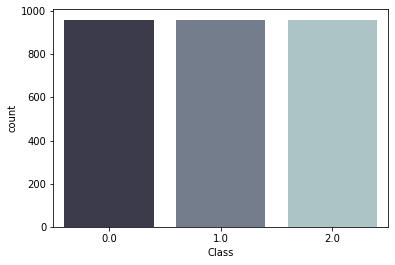

In [31]:
sns.countplot(x=target, data=dataset, palette="bone")
plt.show()

In [32]:
list_cor = pd.DataFrame(dataset[features].corr().unstack().abs().sort_values().drop_duplicates())
list_cor.columns = ['correlation_index']
list_corr_high = list(list_cor[-33:-1]['correlation_index'].index)
list_corr_high

[('P7 theta m', 'AF4 theta m'),
 ('F8 alpha m', 'FC6 alpha m'),
 ('F3 beta std', 'F8 beta std'),
 ('FC6 theta m', 'F8 theta m'),
 ('AF4 beta m', 'F8 beta m'),
 ('AF4 alpha m', 'FC6 alpha m'),
 ('FC6 beta m', 'F8 beta m'),
 ('P7 beta m', 'F3 beta m'),
 ('P7 theta m', 'F3 theta m'),
 ('F3 alpha m', 'FC6 alpha m'),
 ('F3 alpha m', 'AF4 alpha m'),
 ('FC6 theta m', 'P7 theta m'),
 ('P7 theta m', 'F8 theta m'),
 ('T8 beta std', 'P7 beta std'),
 ('F3 theta m', 'FC6 theta m'),
 ('AF4 beta std', 'F8 beta std'),
 ('FC6 beta std', 'F8 beta std'),
 ('F8 beta m', 'T8 beta m'),
 ('F3 beta std', 'P7 beta std'),
 ('FC6 beta m', 'P7 beta m'),
 ('FC6 beta m', 'F3 beta m'),
 ('AF4 beta m', 'P7 beta m'),
 ('FC6 beta m', 'AF4 beta m'),
 ('F8 beta std', 'T8 beta std'),
 ('F8 beta m', 'P7 beta m'),
 ('F3 beta std', 'FC6 beta std'),
 ('FC6 beta std', 'AF4 beta std'),
 ('P7 beta std', 'FC6 beta std'),
 ('F3 beta m', 'AF4 beta m'),
 ('P7 beta std', 'AF4 beta std'),
 ('P7 beta std', 'F8 beta std'),
 ('AF4 beta s


### Missing data


In [33]:
total = dataset[features].isnull().sum().sort_values(ascending = False)
percent = (dataset[features].isnull().sum()/dataset[features].isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing

,Total,Percent
AF4 beta m,0,0.0
AF4 beta std,0,0.0
FC5 alpha m,0,0.0
FC5 beta std,0,0.0
FC5 beta m,0,0.0
...,...,...
T8 beta std,0,0.0
T8 beta m,0,0.0
FC6 delta std,0,0.0
FC6 delta m,0,0.0



## Data Preprocessing


In [34]:
def preprocess_inputs(df, features, target):        
    
    list_cor = pd.DataFrame(df[features].corr().unstack().abs().sort_values().drop_duplicates())
    list_cor.columns = ['correlation_index']
    list_corr_high = list(list_cor[-33:-1]['correlation_index'].index)
    list_corr_high
    
    for eletrods in list_corr_high:
        df['__'.join(list(eletrods))] = df.apply(lambda row: abs(row[eletrods[0]] - row[eletrods[1]]), axis=1)
    
    col = df.columns       # .columns gives columns names in data
    features = col[1:]
    
    y = df.drop(features, axis=1)
    y = to_categorical(y)
    X = df[features]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # Scale X with a standard scaler
    transformer = StandardScaler() 

    X_train_transformer = transformer.fit_transform(X_train)
    X_test_transformer = transformer.transform(X_test)

    return X_train_transformer, X_test_transformer, y_train, y_test


# Model Architecture


## LSTM

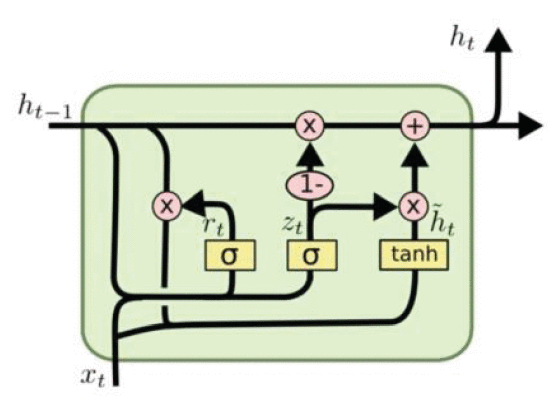

## Building the Model



In [50]:
def build_model(X):  
    k2 = int(X.shape[1]**(1/2))
    inputs = tf.keras.Input(shape=(X.shape[1],))
    expand_dims = tf.reshape(inputs, (-1,k2, k2), name=None)
    lstm = tf.keras.layers.LSTM(32, return_sequences=True)(expand_dims)
    drop = tf.keras.layers.Dropout(.4)(lstm)
    lstm = tf.keras.layers.LSTM(16, return_sequences=True)(expand_dims)
    drop = tf.keras.layers.Dropout(.4)(lstm)
    flatten = tf.keras.layers.Flatten()(lstm)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    
    tf.keras.utils.plot_model(model, to_file = 'model.png')
    
    return model

X_train, X_test, y_train, y_test = preprocess_inputs(dataset, features, target)
lstm_model = build_model(X_train)

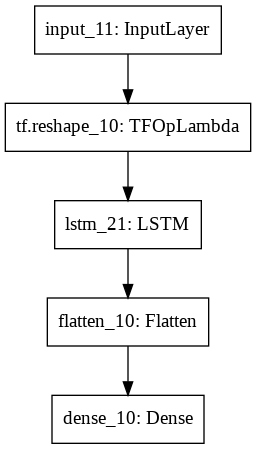

In [51]:
tf.keras.utils.plot_model(lstm_model, to_file = 'lstm_model.png')

In [41]:
def train_model(dataset, features, target, build_model=build_model):
    X_train, X_test, y_train, y_test = preprocess_inputs(dataset, features, target)

    class_model = build_model(X_train)

    history = class_model.fit(
        X_train,
        y_train,
        validation_split=0.3,
        batch_size=32,
        epochs=30,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(history.history['accuracy'])*100, np.std(history.history['accuracy'])*100)) 

    class_acc = class_model.evaluate(X_test, y_test, verbose=0)[1]
    print("Test Accuracy (Class Model): {:.2f}%".format(class_acc * 100))
    
    y_pred = np.array(list(map(lambda x: np.argmax(x), class_model.predict(X_test))))
    clr = classification_report(y_test.argmax(axis=-1) , y_pred)
#     print("Classification Report:\n----------------------\n", clr)
    
    return history

In [42]:
def plot_accuracy_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [43]:
def plot_loss_history(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Accuracy: 66.52% (+/- 8.38%)
Test Accuracy (Class Model): 66.13%


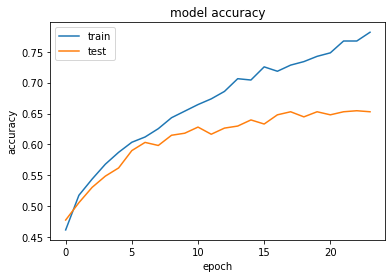

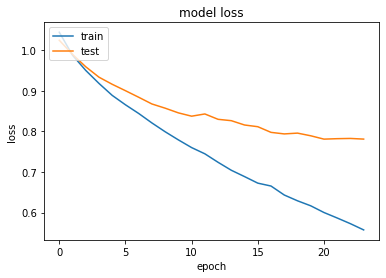

Accuracy: 70.31% (+/- 11.98%)
Test Accuracy (Class Model): 69.83%


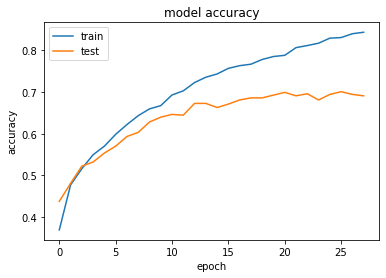

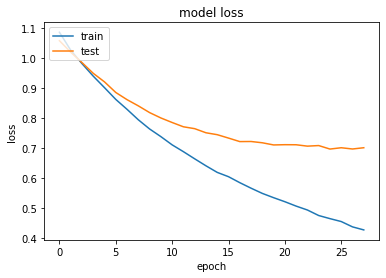

Accuracy: 56.53% (+/- 8.39%)
Test Accuracy (Class Model): 54.68%


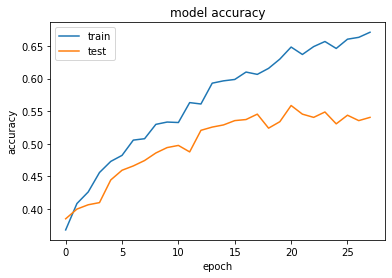

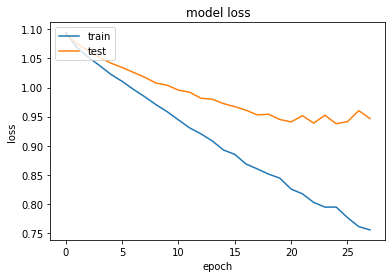

Accuracy: 61.25% (+/- 9.90%)
Test Accuracy (Class Model): 61.27%


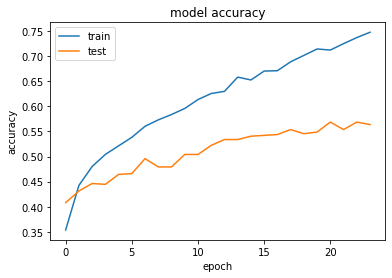

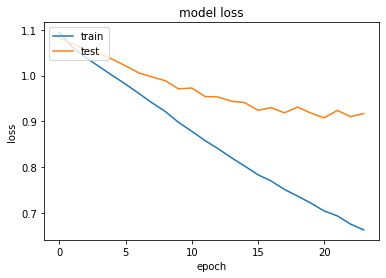

In [44]:
for dfs in dataset_users:
    history = train_model(dfs, features, target)
    plot_accuracy_history(history)
    plot_loss_history(history)